In [1]:
%%time
%%capture
!uv pip install feluda
!uv pip install feluda-vid-vec-rep-clip
!uv pip install feluda-cluster-embeddings

# other packages
!uv pip install opencv-python
!uv pip install matplotlib
!uv pip install huggingface-hub
!uv pip install datasets

CPU times: user 9.45 ms, sys: 29.6 ms, total: 39.1 ms
Wall time: 863 ms


In [2]:
import os
import tarfile

import cv2
import matplotlib.pyplot as plt
from huggingface_hub import hf_hub_download

from feluda import Feluda
from feluda.models.media_factory import VideoFactory


### Dataset Structure Breakdown

- **UCF101_subset/**: The root directory containing the dataset.
  - **train/**: Contains training samples.
    - Each subdirectory under `train/` corresponds to a specific action class:
      - `BenchPress`
      - `BasketballDunk`
      - `BalanceBeam`
      - `ApplyLipstick`
      - `BabyCrawling`
      - `ApplyEyeMakeup`
      - `Archery`
      - `BandMarching`
      - `BaseballPitch`
      - `Basketball`
  - **test/**: Same as train.
  - **val/**: Same as train.

We'll take train subset as our example here.

In [3]:
# Downloading and extracting

dataset_name = "UCF101_subset/train"
hf_dataset_identifier = "sayakpaul/ucf101-subset"
filename = "UCF101_subset.tar.gz"
file_path = hf_hub_download(
    repo_id=hf_dataset_identifier, filename=filename, repo_type="dataset"
)


with tarfile.open(file_path) as t:
    t.extractall(".")

In [4]:
file_path

'/home/priyash7/.cache/huggingface/hub/datasets--sayakpaul--ucf101-subset/snapshots/b9984b8d2a95e4a1879e1b071e9433858d0bc24a/UCF101_subset.tar.gz'

### Initializing Feluda class with config file

We'll use two operators for this example. One for extracting embeddings and other for clustering.

In [5]:
feluda = Feluda("02_plot_cluster_videos_config.yml")
feluda.setup()

# Extracting operator name from config and getting operators from Feluda
cluster_operator = feluda.operators.get()["cluster_embeddings"]
vid_vec_clip_operator = feluda.operators.get()["vid_vec_rep_clip"]

Installing packages for vid_vec_rep_clip


In [6]:
def get_video_thumbnail(video_path, save_path):
    """Extract and save the first frame from the video as a thumbnail."""
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()  # Read the first frame
    if ret:
        thumbnail_path = os.path.join(
            save_path, os.path.basename(video_path).replace(".avi", "_thumbnail.jpg")
        )
        cv2.imwrite(thumbnail_path, frame)  # Save the thumbnail as a JPEG
        cap.release()
        return thumbnail_path  # Return the path to the saved thumbnail
    cap.release()
    return None

In the below codeblock, we are extracting embeddings from video using vid_vec_clip operator.

In [7]:
operator_parameter = []
sub_folder_name = os.listdir(f"{dataset_name}")

for class_dir in sub_folder_name:
    temp_list = os.listdir(os.path.join(dataset_name, class_dir))

    i = 0
    while i < len(temp_list) and i < 5:
        if temp_list[i] == "UCF101":
            i += 1
            continue

        video_full_path = os.path.join(dataset_name, class_dir, temp_list[i])

        # Extract and save the video thumbnail before processing
        thumbnail_save_dir = "thumbnails"
        os.makedirs(thumbnail_save_dir, exist_ok=True)
        thumbnail_path = get_video_thumbnail(video_full_path, thumbnail_save_dir)

        video_path = VideoFactory.make_from_file_on_disk(
            os.path.join(dataset_name, class_dir, temp_list[i])
        )
        embedding = vid_vec_clip_operator.run(video_path)
        average_vector = next(embedding)

        operator_parameter.append(
            {
                "payload": os.path.join(
                    dataset_name, class_dir, temp_list[i]
                ),  # Use the current item as the payload
                "embedding": average_vector.get("vid_vec"),
            }
        )
        i += 1

After extracting embeddings from vid_vec_clip operator, we now pass the embeddings to clustering operator to cluster videos based on their embeddings.

In [8]:
# Using clustering algorithm

clusters = cluster_operator.run(operator_parameter, n_clusters=10, modality="video")
clusters = {key: clusters[key] for key in sorted(clusters)}  # Sorted based on keys

### Visualizing Clusters

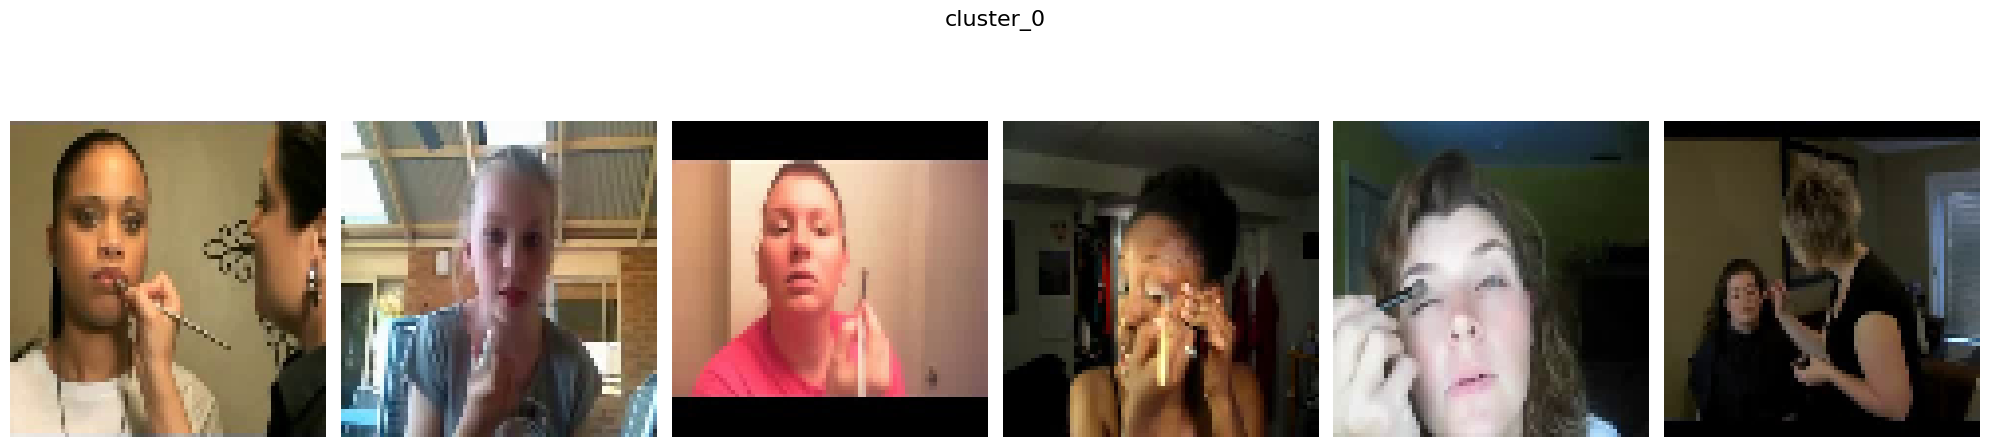

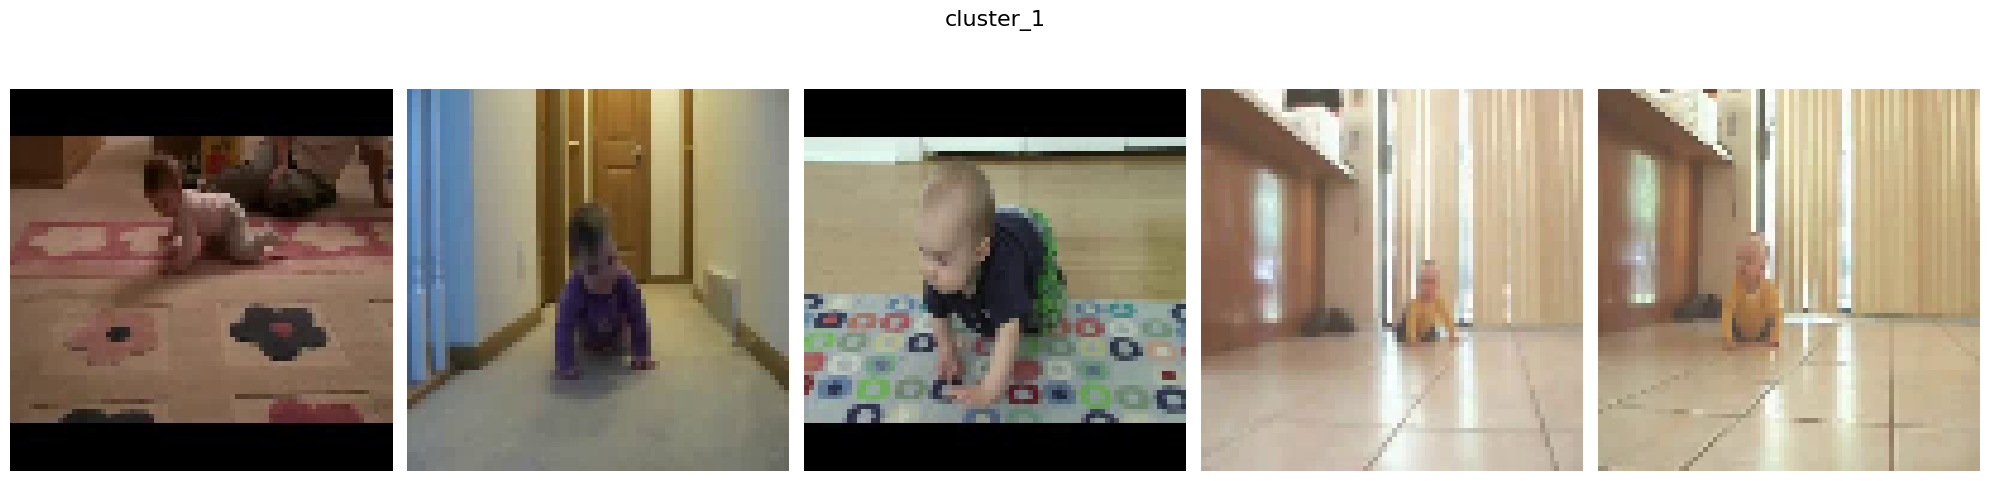

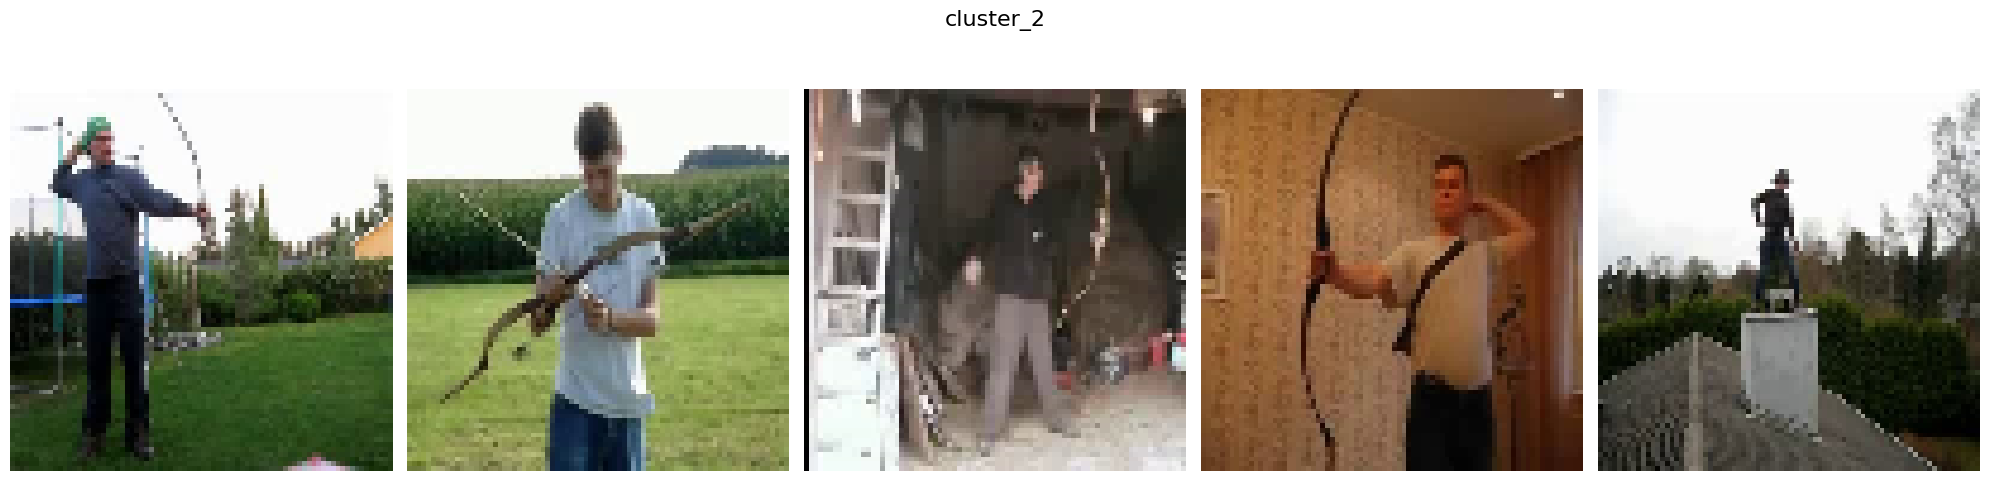

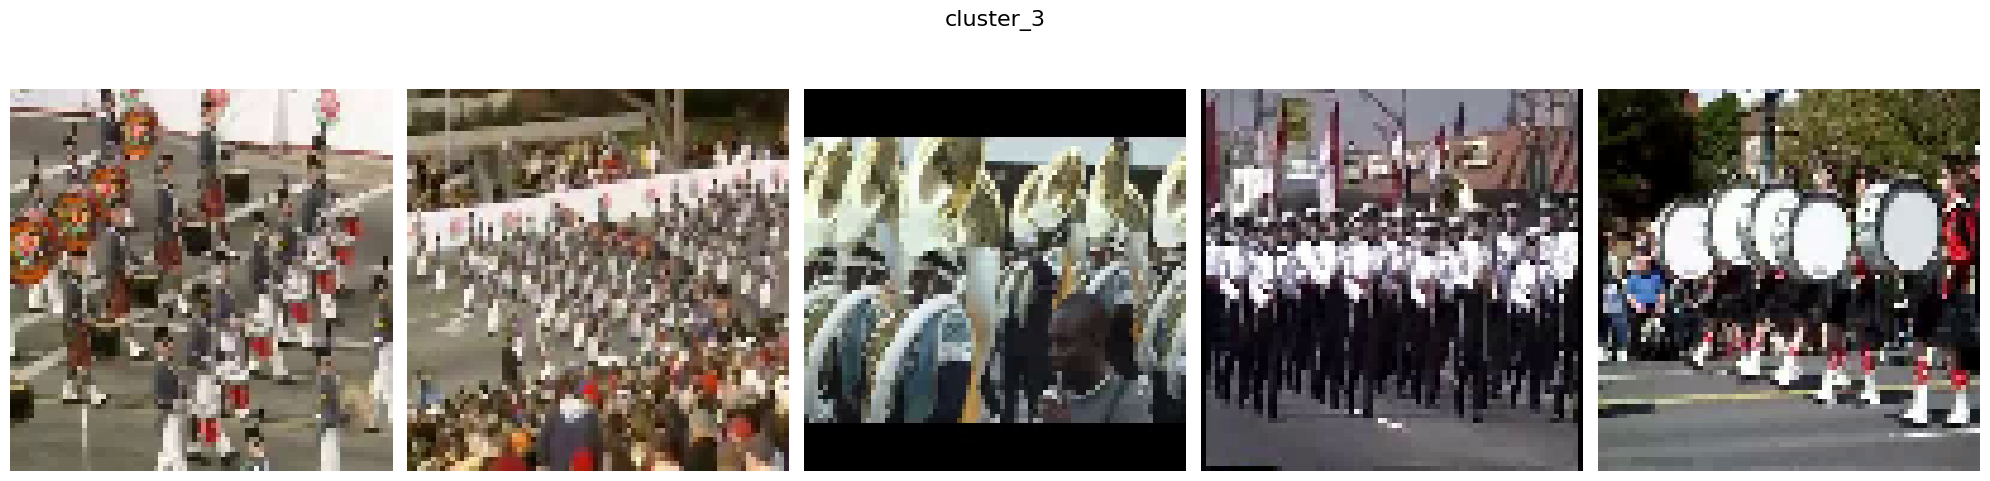

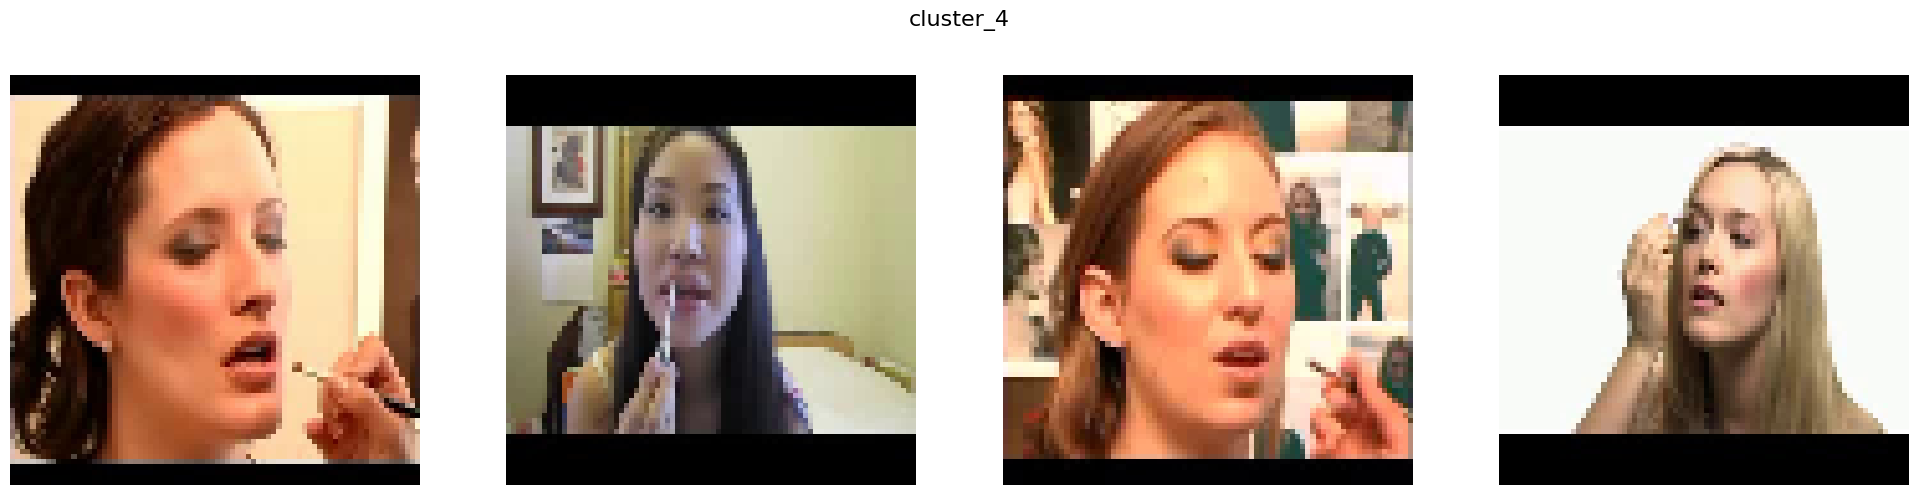

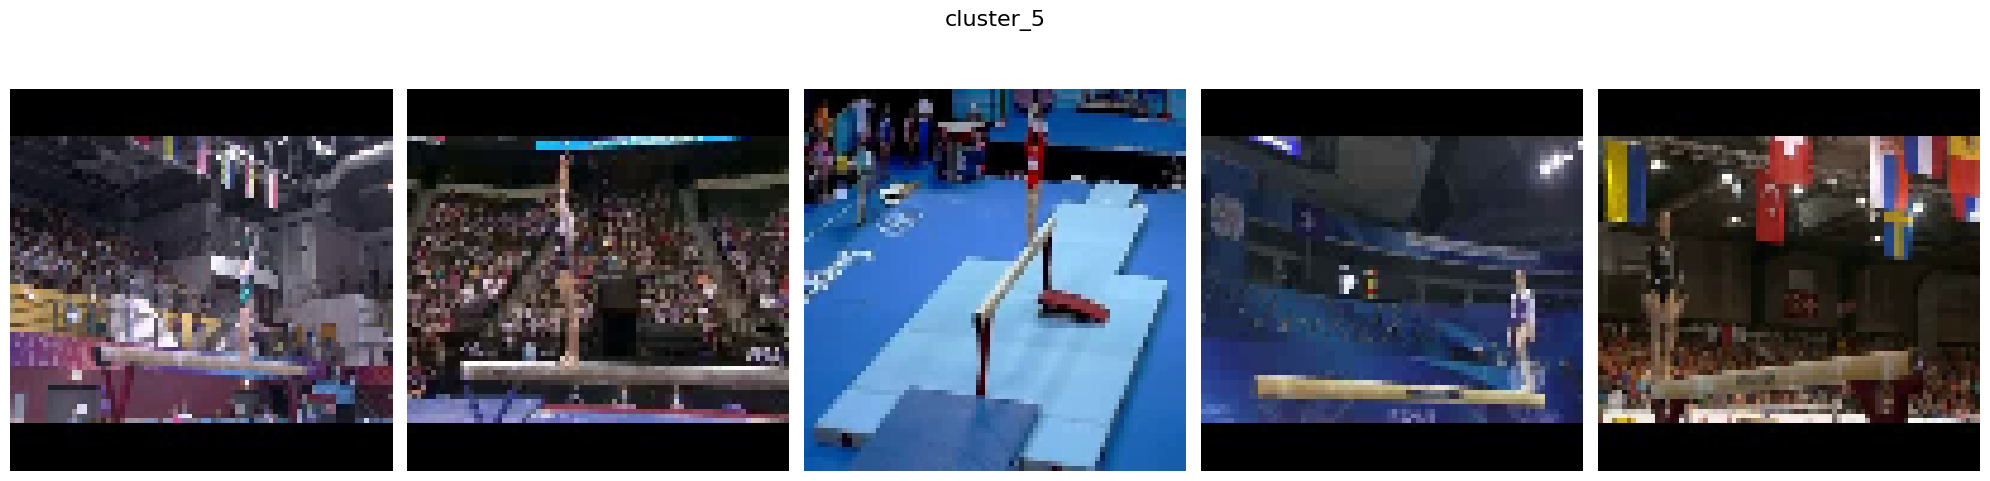

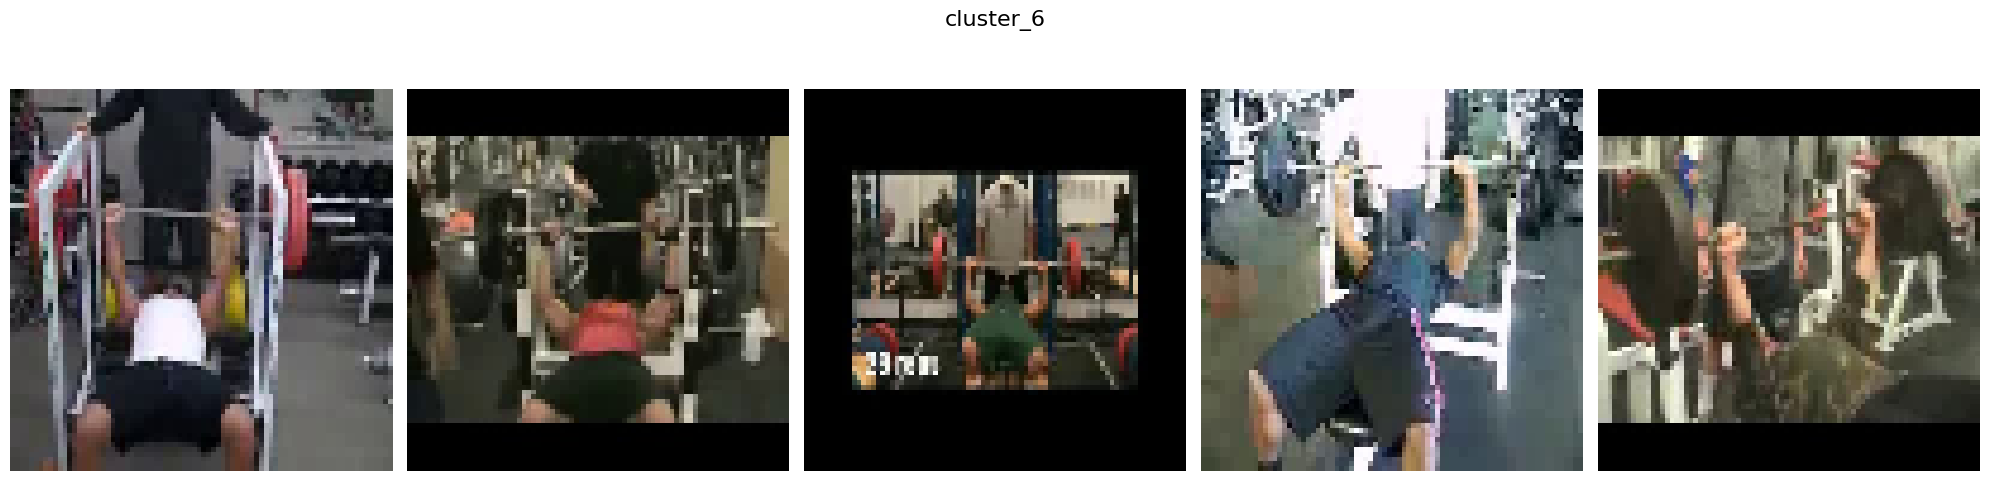

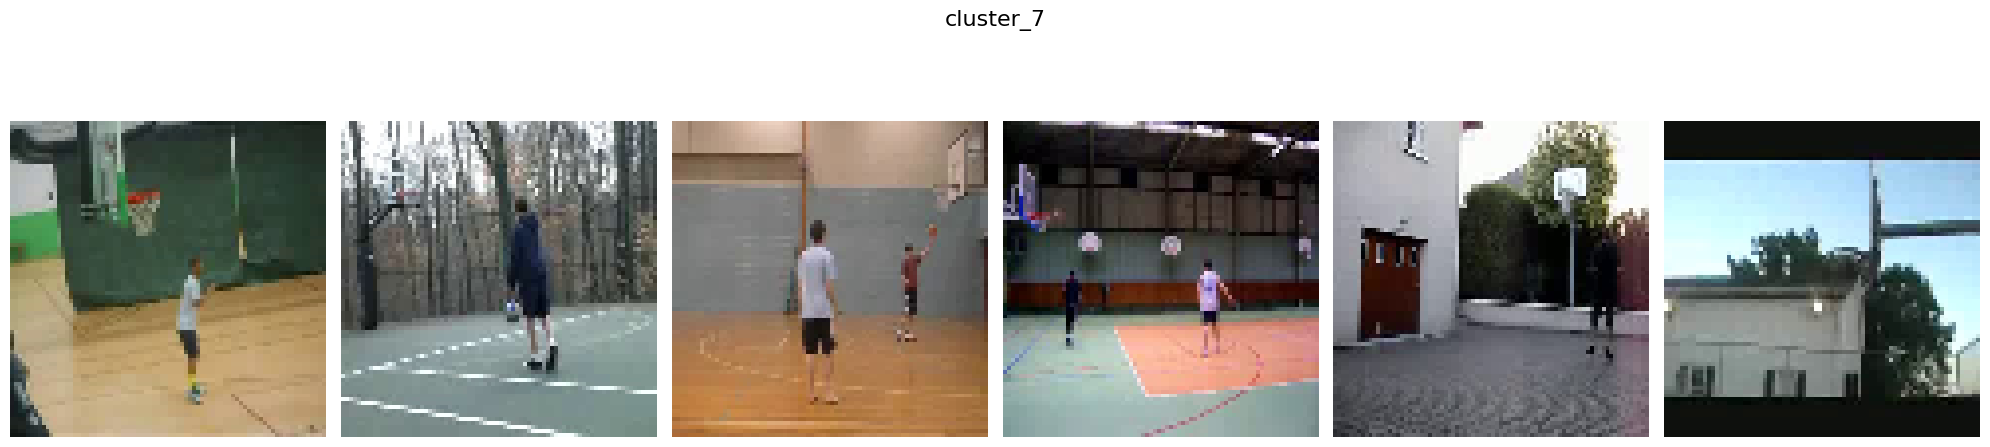

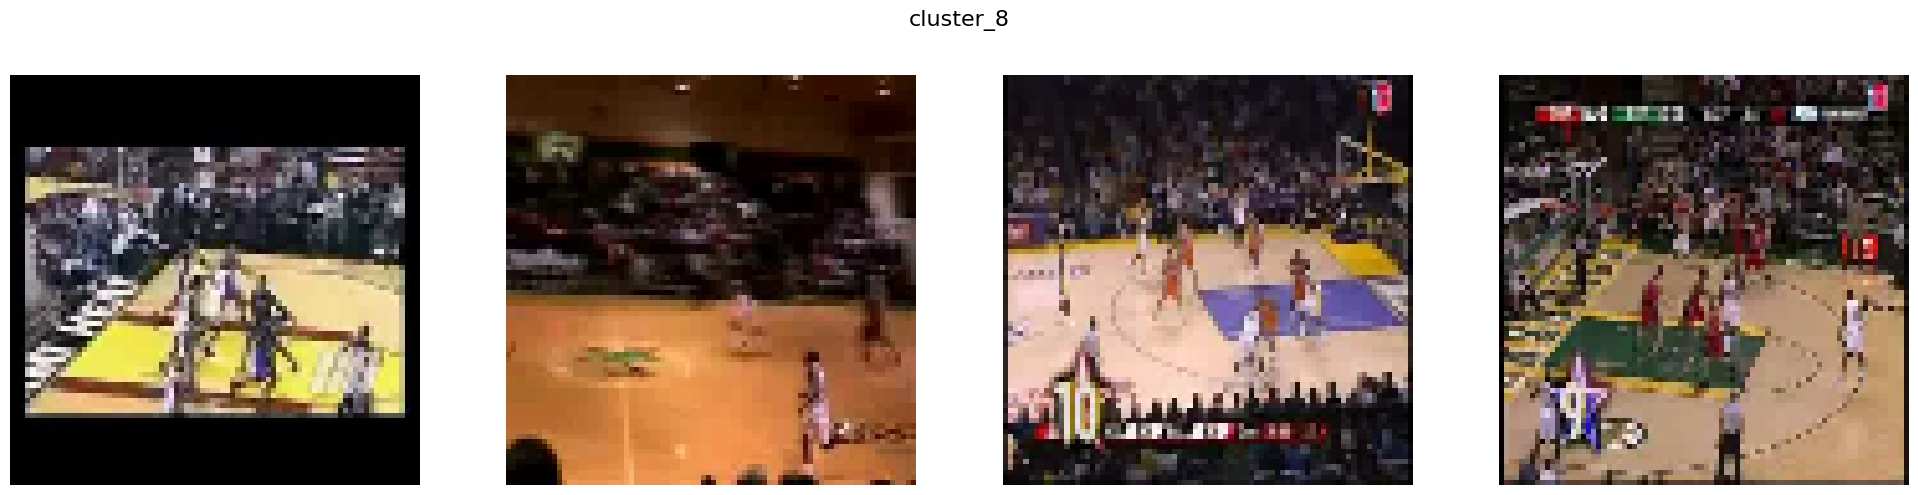

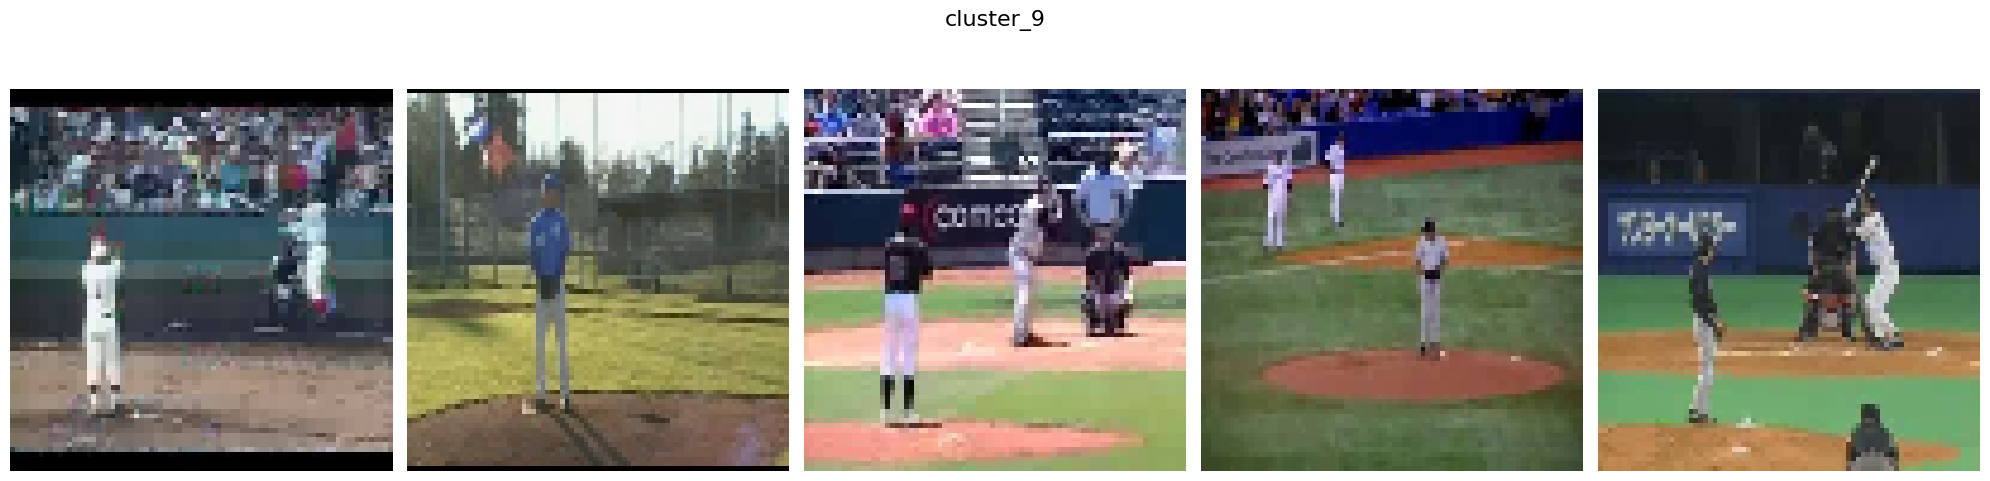

In [9]:
thumbnail_folder = "thumbnails"


def load_thumbnail(payload):
    """Load the thumbnail from the pre-saved thumbnail folder."""
    video_filename = os.path.basename(payload)
    thumbnail_filename = video_filename.replace(".avi", "_thumbnail.jpg")
    thumbnail_path = os.path.join(thumbnail_folder, thumbnail_filename)

    if os.path.exists(thumbnail_path):
        return cv2.imread(thumbnail_path)
    else:
        print(f"Thumbnail not found for {video_filename}")
    return None


for cluster_label, video_paths in clusters.items():
    num_videos = len(video_paths)

    fig, axes = plt.subplots(1, num_videos, figsize=(20, 5))

    for i, video_path in enumerate(video_paths):
        video_thumbnail = load_thumbnail(video_path)
        if video_thumbnail is not None:
            video_thumbnail = cv2.cvtColor(
                cv2.resize(video_thumbnail, (80, 80)), cv2.COLOR_BGR2RGB
            )
            axes[i].imshow(video_thumbnail)
            axes[i].axis("off")

    plt.suptitle(f"{cluster_label}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

In [10]:
# Cleaning cell
import shutil

shutil.rmtree("thumbnails")
shutil.rmtree("UCF101_subset")
os.remove(file_path)